In [1]:
import os

import numpy as np
import polars as pl
import seaborn as sns

In [2]:
# defaults
model_name = "funnel10"
sns.set_theme(style="white")

# General

In [3]:
path = os.path.join("../data/processed/", model_name, "samples.parquet")
samples = pl.read_parquet(path)

In [4]:
# add column "config" that represents each unique sampler configuration
# each unique sampler configuration is a unique combination of all columns except for the parameter columns p0, p1, ...

# get all columns except for the parameter columns
sampler_param_cols = [col for col in samples.columns if not col.startswith("p")]

# get all unique sampler configurations
configs = samples[sampler_param_cols].unique()

# add column "config" to config Polars dataframe
configs = configs.with_columns(pl.Series("config", range(0, len(configs))))

# add column "config" to samples Polars dataframe, based on the config Polars dataframe
samples = samples.join(configs, on=sampler_param_cols, how="inner")

In [22]:
samples

run,sampler,stepcount,stepsize,reduction_factor,dampening,num_proposals,probabilistic,grad_evals,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,config
u8,cat,u16,f32,u8,f32,u8,bool,u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64
0,"""drghmc""",0,0.12063,2,0.2,1,false,1001,3.515625,-1.700195,-0.709961,-0.089539,0.109192,1.105469,-2.224609,-1.019531,-0.990723,2.449219,0
0,"""drghmc""",0,0.12063,2,0.2,1,false,1001,3.466797,-1.693359,-0.711426,-0.085815,-0.013527,1.06543,-2.164062,-0.948242,-1.073242,2.380859,0
0,"""drghmc""",0,0.12063,2,0.2,1,false,1001,3.427734,-1.671875,-0.741211,-0.088074,-0.089111,1.09375,-2.164062,-0.818359,-1.088867,2.355469,0
0,"""drghmc""",0,0.12063,2,0.2,1,false,1001,3.451172,-1.567383,-0.688965,-0.032837,-0.141113,1.067383,-2.164062,-0.673828,-1.15918,2.349609,0
0,"""drghmc""",0,0.12063,2,0.2,1,false,1001,3.417969,-1.501953,-0.661621,-0.034393,-0.111877,1.021484,-2.150391,-0.556152,-1.152344,2.400391,0
0,"""drghmc""",0,0.12063,2,0.2,1,false,1001,3.384766,-1.414062,-0.593262,-0.062683,-0.006363,0.922852,-2.167969,-0.409668,-1.144531,2.535156,0
0,"""drghmc""",0,0.12063,2,0.2,1,false,1001,3.3359375,-1.383789,-0.587891,-0.060547,0.113342,0.891113,-2.214844,-0.205322,-1.149414,2.722656,0
0,"""drghmc""",0,0.12063,2,0.2,1,false,1001,3.296875,-1.310547,-0.575684,-0.084167,0.161987,0.801758,-2.236328,0.020584,-1.161133,2.84375,0
0,"""drghmc""",0,0.12063,2,0.2,1,false,1001,3.228516,-1.21875,-0.663086,-0.088379,0.180176,0.7265625,-2.257812,0.231445,-1.141602,2.919922,0


# Accuracy Evaluation

In [5]:
# compute a new Polars dataframe with the mean of draws for each parameter p0, p1, ... grouped by sampler parameters

# list of all columns that do not start with p and are followed by an integer
sampler_param_cols = [col for col in samples.columns if not (col.startswith("p") and col[1:].isdigit()) or not col.startswith("run") ]

# group by all non-p columns and compute the mean of each p column
samples_means = samples.group_by(sampler_param_cols).mean()

In [6]:
# plot the mean of each p column with seaborn box plots
# stratify by run and make each panel a different parameter, 
# from columns p0, p1, p2, ...

# melt the dataframe to long format
samples_means_long = samples_means.melt(
    id_vars=sampler_param_cols, value_vars=[f"p{i}" for i in range(10)]
)

In [7]:
# data = samples_means_long.to_pandas(
#     use_pyarrow_extension_array=True
# )
# # drop stepsize, reduction_factor, dampening, num_proposals, probailistic, and grad_evals from data, a Pandas dataframe
# data = data.drop(
#     columns=[
#         "stepsize",
#         "stepcount",
#         "reduction_factor",
#         "dampening",
#         "num_proposals",
#         "probabilistic",
#         "grad_evals",
#         "p0",
#         "p1",
#         "p2",
#         "p3",
#         "p4",
#         "p5",
#         "p6",
#         "p7",
#         "p8",
#         "p9",
#     ]
# )

In [20]:
data = samples_means_long
data = data.drop(
    columns=[
        "stepsize",
        "stepcount",
        "reduction_factor",
        "dampening",
        "num_proposals",
        "probabilistic",
        "grad_evals",
        "p0",
        "p1",
        "p2",
        "p3",
        "p4",
        "p5",
        "p6",
        "p7",
        "p8",
        "p9",
    ]
)
data_downsample = data.sample(n=5000, seed=1234)


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


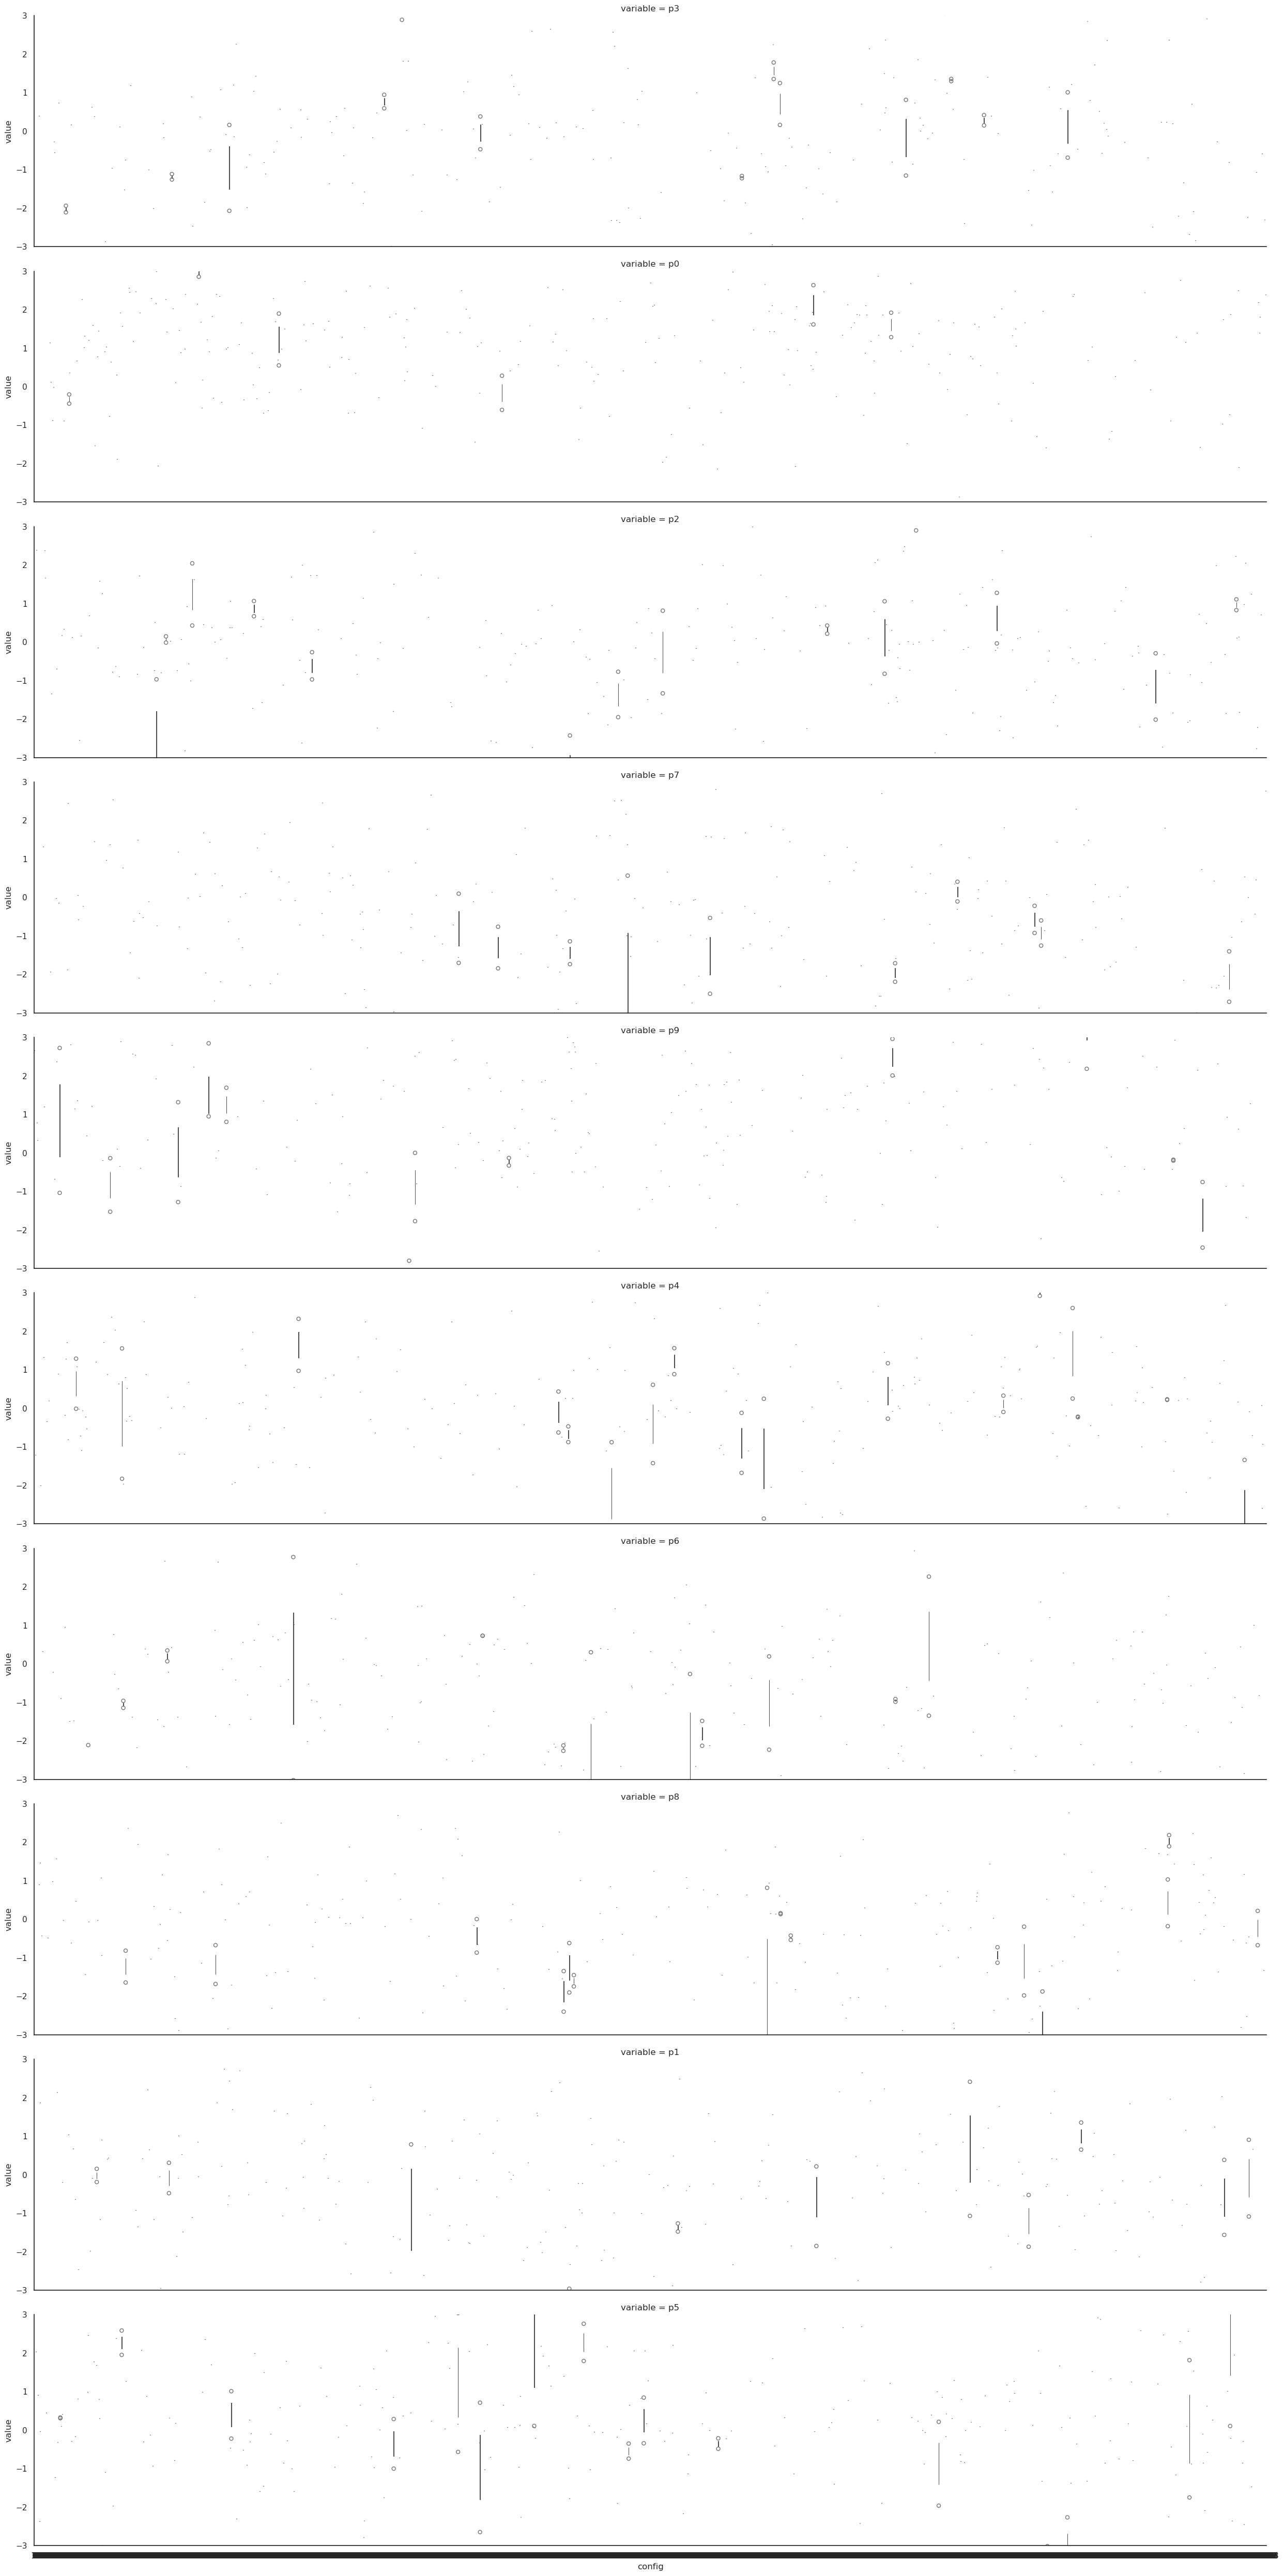

In [21]:
fig = sns.catplot(
    data=data_downsample,
    y="value",
    x="config",
    col="variable",
    kind="boxen",
    col_wrap=1,
    facet_kws={"ylim" : (-3, 3)},
    aspect=5,
)

# Efficency Evaluation